# Employee Promotion Prediction

HR analytics is the process of collecting and analysing Human Resource (HR) data in order to improve an organization's workforce. It can help to answer critical questions about the organization which enables better and data-driven decision-making. Managing promotions effectively is one of the most powerful ways leaders can drive their company’s success. Promotion’s process allows leaders to evaluate each employee and their potential to be promoted. Some analysis needs to be conducted to estimate the probability of getting promotion based on some features. Therefore, this project aims to perform predictive analysis to identify the employees most likely to get promoted. 

The data size is over 54808 observations and was obtained from Kaggle. The variables which are available in this dataset are: 


* Employee ID: Unique ID for employee.
* Age: Age of Employee.
* Previous Year Rating: Employee Rating for the previous year
* Length of service: Length of service in years
* Avg training score: Average score in current training evaluations.
* Number of trainings: no. of other trainings completed in previous year on soft skills, technical skills etc.
* Awards won: If awards won during previous year then 1 else 0 .
* Department: Department of employee.
* Education: Education Level.
* Region: Region of employment.
* Gender: Gender of Employee.
* Recruitment channel: Channel of recruitment for employee.
* Is promoted (Target variable): Recommended for promotion.

In [1]:
# munging imports
import numpy as np
import pandas as pd
import scipy.stats as stats

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

%matplotlib inline 

# modeling imports
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report



In [2]:
# load data and explore the data type at each series
data = pd.read_csv('project_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  awards_won?           54808 non-null  int64  
 11  avg_training_score    54808 non-null  int64  
 12  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 5.4+ MB


As it can be seen from the information above that our data contains 13 columns 8 of them are numerical variables and the others are categorical. Also, some missing data were observed in each of education and previous_year_rating columns.

# Exploratory Data Analysis

In [3]:
# check missing value 

data.isna().sum()
missing_value = 100 * data.isnull().sum()/len(data)
missing_value = missing_value.reset_index()
missing_value.columns = ['variables','missing values in percentage']



In [4]:
# Visualize missing value percentage

fig=px.bar(missing_value, y='missing values in percentage',x='variables',title='Missing values % in each column',template='gridon',color_discrete_sequence=px.colors.sequential.Viridis_r);
fig.update_yaxes( # the y-axis is in dollars
    tickprefix="%", showgrid=True)
fig.show()

The precentage of missing values for both education and previous_year_rating columns were less than 10%, therefore we can delete them and this will not affect the dataset.

In [5]:
# Drop missing rows that contain missing data and check the data again 

data=data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48660 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           48660 non-null  int64  
 1   department            48660 non-null  object 
 2   region                48660 non-null  object 
 3   education             48660 non-null  object 
 4   gender                48660 non-null  object 
 5   recruitment_channel   48660 non-null  object 
 6   no_of_trainings       48660 non-null  int64  
 7   age                   48660 non-null  int64  
 8   previous_year_rating  48660 non-null  float64
 9   length_of_service     48660 non-null  int64  
 10  awards_won?           48660 non-null  int64  
 11  avg_training_score    48660 non-null  int64  
 12  is_promoted           48660 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 5.2+ MB


In [6]:
# check the first five rows

data.head(5)

employee_id         department     region         education gender  \
0        65438  Sales & Marketing   region_7  Master's & above      f   
1        65141         Operations  region_22        Bachelor's      m   
2         7513  Sales & Marketing  region_19        Bachelor's      m   
3         2542  Sales & Marketing  region_23        Bachelor's      m   
4        48945         Technology  region_26        Bachelor's      m   

  recruitment_channel  no_of_trainings  age  previous_year_rating  \
0            sourcing                1   35                   5.0   
1               other                1   30                   5.0   
2            sourcing                1   34                   3.0   
3               other                2   39                   1.0   
4               other                1   45                   3.0   

   length_of_service  awards_won?  avg_training_score  is_promoted  
0                  8            0                  49            0  
1                  4            0                  60            0  
2                  7            0                  50            0  
3                 10            0                  50            0  
4                  2            0                  73            0

In [7]:
# computing the five statistical summary for numerical variables and check if there is any unusual values. 

data.describe()

employee_id  no_of_trainings           age  previous_year_rating  \
count  48660.000000     48660.000000  48660.000000          48660.000000   
mean   39169.271681         1.251993     35.589437              3.337526   
std    22630.461554         0.604994      7.534571              1.257922   
min        1.000000         1.000000     20.000000              1.000000   
25%    19563.500000         1.000000     30.000000              3.000000   
50%    39154.000000         1.000000     34.000000              3.000000   
75%    58788.250000         1.000000     39.000000              4.000000   
max    78298.000000        10.000000     60.000000              5.000000   

       length_of_service  awards_won?  avg_training_score   is_promoted  
count        48660.00000  48660.00000        48660.000000  48660.000000  
mean             6.31157      0.02314           63.603309      0.086971  
std              4.20476      0.15035           13.273502      0.281795  
min              1.00000      0.00000           39.000000      0.000000  
25%              3.00000      0.00000           51.000000      0.000000  
50%              5.00000      0.00000           60.000000      0.000000  
75%              8.00000      0.00000           76.000000      0.000000  
max             37.00000      1.00000           99.000000      1.000000

The table above shows five statistical summary of numerical features in the dataset. The middle 50% of age is 34, with an average age of 35. The minimum value of number of trainings is one, whereas the maximum value is 10. However, the mean of previous year rating is 3, with minimum rating of 1 and maximum rating of 5. Furthermore, the mean and the median of length of service are 6 and 5 respectively. Finally, the avg training score has the mean of 63 with minimum and maximum score of 39 and 99 respectively

In [8]:
# summary for categorical variables

data.describe(include = 'object')

department    region   education gender recruitment_channel
count               48660     48660       48660  48660               48660
unique                  9        34           3      2                   3
top     Sales & Marketing  region_2  Bachelor's      m               other
freq                14239     10811       33404  33852               27017

In [9]:
# frequency of each category in Department variable
plot_1 = data['department'].value_counts().reset_index()
plot_1.columns = ['department','Count']

px.bar(plot_1,x='department',y='Count',text='Count',title='Department',color='Count',template='gridon')

It can be seen from the plot above that around 29.2% of employees were in Sales& Marketing department followed by 21.7% of employees were in operations department. Unlike the other departments like R&D and Legal that had the lower percentage of 1.84% 1.78% respectively.

In [10]:
# check the value counts of the target variable is_promoted 


plot_2 = data['is_promoted'].value_counts().reset_index()
plot_2.columns = ['is_promoted','Count']


px.bar(plot_2,x='is_promoted',y='Count',template='gridon',text='Count',title='Promoted',color='Count')

The figure above shows that around 8% of employees most likely to get promoted.

In [11]:
# visualizing previous year rating


plot_3 = data['previous_year_rating'].value_counts().reset_index()
plot_3.columns = ['previous_year_rating','Count']

px.bar(plot_3,x='previous_year_rating',y='Count',template='gridon',text='Count',title='Previous year rating',color='Count')

The plot above shows the majority of the employees (79.6%) had previous year rating of 3 or above.

C:\Users\shosh\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



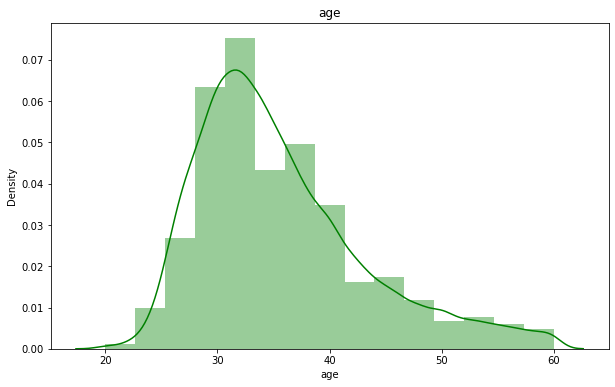

In [12]:
# plot of the distribution of age 

plt.figure(figsize=(10,6))
sns.distplot(data['age'],bins=15,color='green');
plt.title('age');

In [13]:

# visualizing length_of_service

px.bar(data['length_of_service'].value_counts(),title = 'Experience',template='gridon',text=data['length_of_service'].value_counts(),color=data['length_of_service'].value_counts(), labels={"index":"length of service", "value":"counts" })

The majority of the employees had years of experience between 2 to 7, while the minority of them had over 20 years experience.

In [14]:
# visualizing the distribution of promoted and non-promoted based on no_of_trainings 

px.histogram(data,x="no_of_trainings",color="is_promoted",template='gridon',nbins=10,color_discrete_sequence=px.colors.sequential.Viridis_r )

It can be seen that among all employees who got one training the last year that 9% of them are likely to get promoted. Moreover, 7.7% of employees who got two trainings are likely to get promoted. The distribution indicates that few employees were getting number of trainings above 4.

## Some insights from data

**Q1-What is the probability of getting Promoted, If an employee has won an award?**

In [15]:
# counting employees who won an award if they got promoted or not 
award_wining_employees = data[data['awards_won?'] == 1]  #1126 rows employees won an award
award_wining_employees['is_promoted'].value_counts()


0    622
1    504
Name: is_promoted, dtype: int64

In [16]:
dd = {'Is promoted': ["No","Yes"], 'Awards won': [622,504]}  

# Create DataFrame  
pd.DataFrame(dd) 

Is promoted  Awards won
0          No         622
1         Yes         504

In [17]:
# visualizing probability of getting Promoted

fig5 = px.pie(dd,values='Awards won',names='Is promoted',title = 'Promoted after wining awards',color_discrete_sequence=px.colors.sequential.Viridis_r )
fig5.show()

Therefore, The probability of an employee who won awards to get promotion is : 44.8%

**Q2-How the employees differ by getting promotion based on their level of Education?**

In [19]:
# counting employees who have Master's & above if they got promoted or not
educationM_employees = data[data['education'] == "Master's & above"]  #14798 rows employees have Master's & above
educationM_employees['is_promoted'].value_counts()
d3 = {'is_promoted': ["No","Yes"], 'Master and above': [13335,1463]}    
pd.DataFrame(d3)
px.pie(d3,values='Master and above',names='is_promoted',title='Master and above',color_discrete_sequence=px.colors.sequential.Viridis_r)


Among all employees who had Master's and above degree 9.89% of them were more likely to get promotion.

In [18]:
# counting employees who have Bachelor if they got promoted or not


educationB_employees = data[data['education'] == "Bachelor's"]  #33404  employees have Bachelor
educationB_employees['is_promoted'].value_counts()
d2 = {'Is promoted': ["No","Yes"], 'Bachelor': [30671,2733]}    
pd.DataFrame(d2)
px.pie(d2,values='Bachelor',names='Is promoted',title='Bachelor',color_discrete_sequence=px.colors.sequential.Viridis_r )


Among all employees who had Bachelor degree 8.18% of them were more likely to get promotion.

In [20]:
# counting employees who have Below Secondary if they got promoted or not


educationS_employees = data[data['education'] == "Below Secondary"]  
educationS_employees['is_promoted'].value_counts()
d4 = {'is_promoted': ["No","Yes"], 'Below Secondary': [422,36]}    
pd.DataFrame(d4)
px.pie(d4,values='Below Secondary',names='is_promoted',title='Below Secondary',color_discrete_sequence=px.colors.sequential.Viridis_r)



Among all employees who had Below Secondary degree 7.86% of them were more likely to get promotion.

**Q3-Is there any statistically significant difference in the average previous year rating between promoted and non-promoted employees?**

In [21]:
data_0=data[data["is_promoted"]==0]
data_new_0=data_0["previous_year_rating"]
data_new_0=pd.array(data_new_0)
data_1=data[data["is_promoted"]==1]
data_new_1=data_1["previous_year_rating"]
data_new_1=pd.array(data_new_1)
print(data_new_1)

<PandasArray>
[5.0, 5.0, 4.0, 3.0, 5.0, 4.0, 3.0, 5.0, 5.0, 5.0,
 ...
 5.0, 5.0, 4.0, 2.0, 5.0, 5.0, 4.0, 4.0, 3.0, 3.0]
Length: 4232, dtype: float64


In [22]:
# assumption of homogeneity of variance
print(np.std(data_new_0))
print(np.std(data_new_1))


1.2585167762513458
1.0526062150260214


In [23]:
stats.ttest_ind(a=data_new_0, b=data_new_1, equal_var=True)

Ttest_indResult(statistic=-35.45971671477248, pvalue=6.116972903075638e-272)

In [24]:
stats.ttest_ind(a=data_new_0, b=data_new_1, equal_var=False)

Ttest_indResult(statistic=-41.07505584258497, pvalue=0.0)

The T-test statistic indicates that there is a statistically significant difference in the average previous year rating between promoted and non-promoted employees.

In [25]:
# drop unnecessary variable 
dataencoding=data.drop("employee_id", axis="columns")

In [26]:
# encoding data to create pairplot 


le = LabelEncoder()
dataencoding['education'] = le.fit_transform(dataencoding['education'])
dataencoding['department'] = le.fit_transform(dataencoding['department'])
dataencoding['gender'] = le.fit_transform(dataencoding['gender'])
dataencoding['recruitment_channel'] = le.fit_transform(dataencoding['recruitment_channel'])


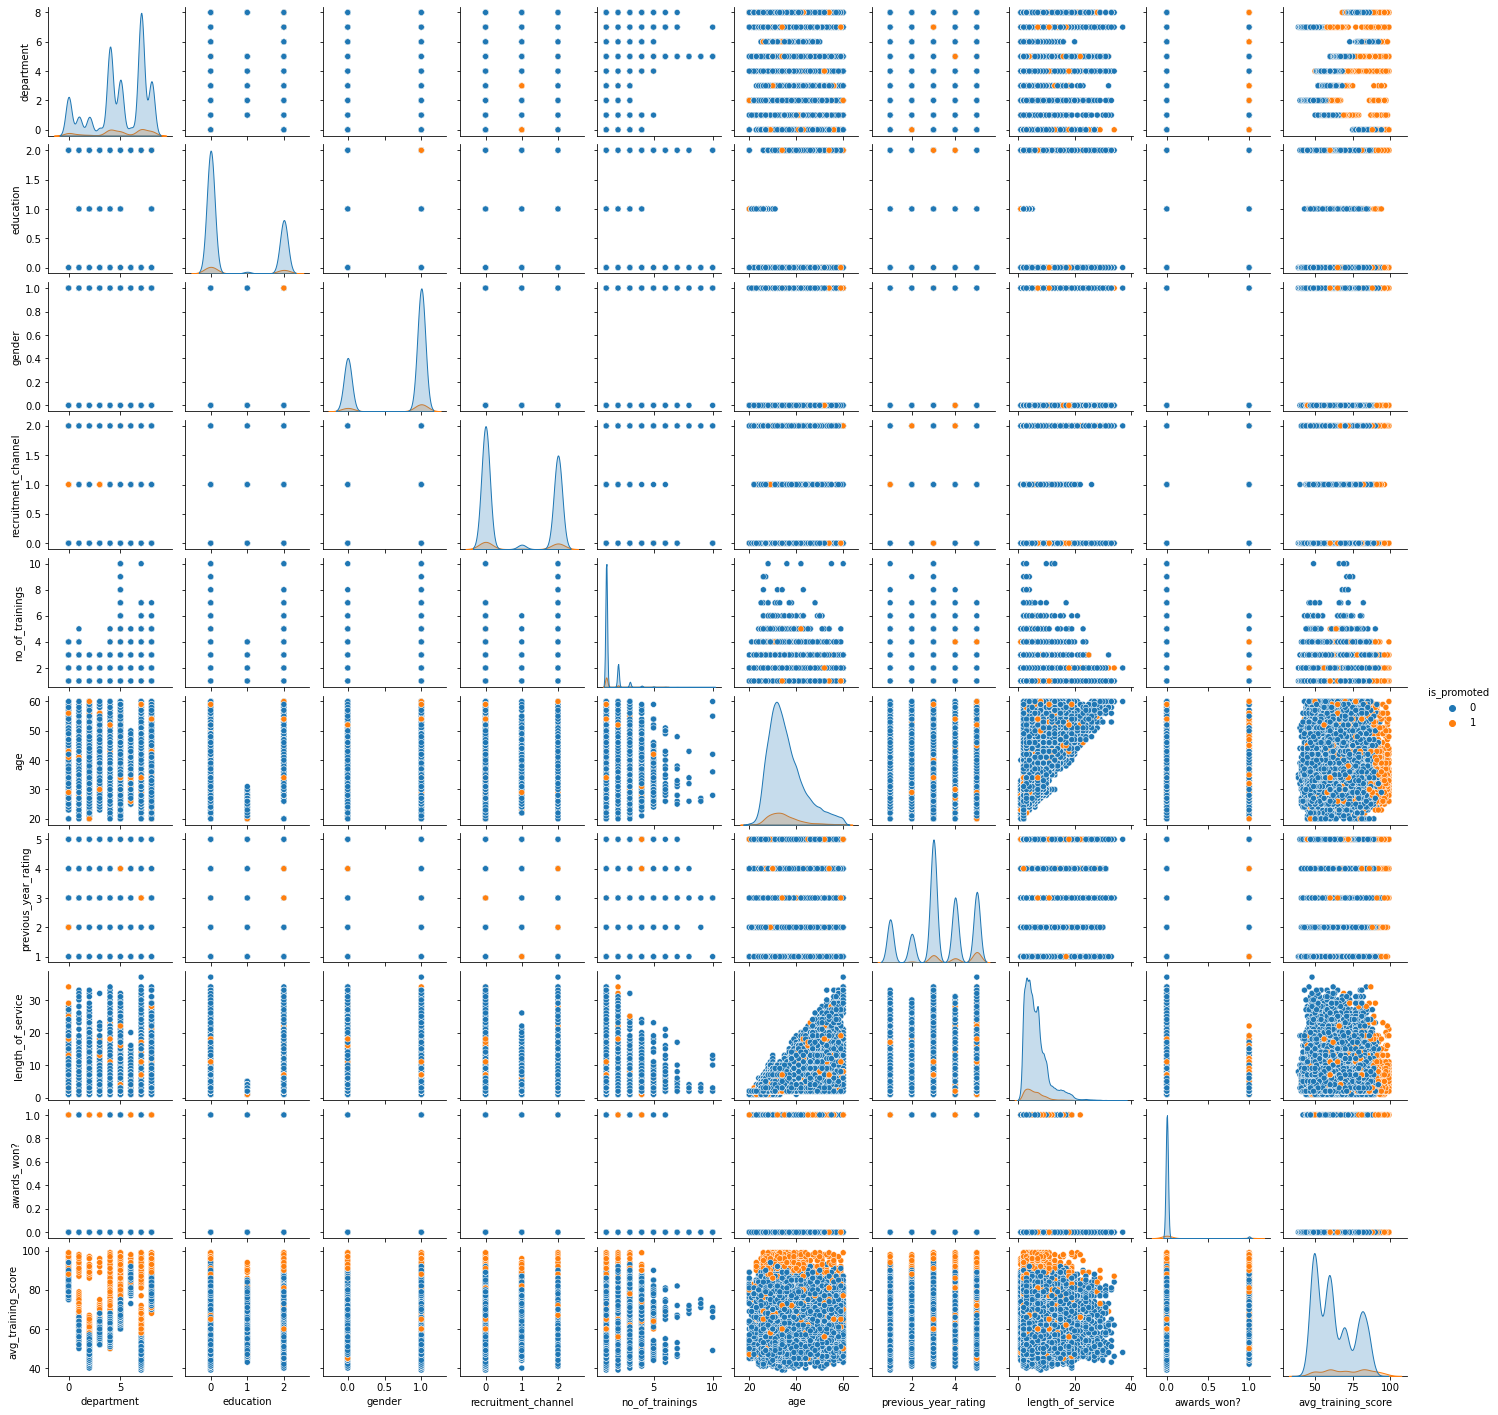

In [27]:
sns.pairplot(data=dataencoding, diag_kind="kde", hue="is_promoted",height=2);
plt.savefig('spair2.png')

The pairplot can be helpful to explore if we have good predictors that can split our classes. By examining the diagonal line, we can see that the overlap area is high in most features.

# Formal Data Analysis

### Data pre-processing

**Log Transformation**: 
Apply log transformation on skewed variables(no_of_trainings and length_of_service) will help us to improve the model performance in modeling part.

In [28]:

# delete unnecessary Column from the dataset

data1=data.drop("employee_id", axis="columns")

In [29]:
# Apply log transformatiom on both no_of_trainings and length_of_service 

data1["no_of_trainings"]=np.log(data1["no_of_trainings"])
data1["length_of_service"]=np.log(data1["length_of_service"])

**Synthetic Minority Oversampling**:SMOTE will be used as Synthetic Minority Oversampling technique, this can handle the issue of imbalanced classes.

In [30]:
# Split the data into X feature matrix and Y target matrix 

X=data1.drop("is_promoted", axis="columns")
y=data1["is_promoted"]

In [31]:
# transform multiple categorical features into dummy variables

X=pd.get_dummies(X,drop_first=True)


In [32]:
# check if my target have a balanced between classes

y.value_counts()

0    44428
1     4232
Name: is_promoted, dtype: int64

In [33]:
# applied SMOTE to fix imbalanced classes

smote=SMOTE(sampling_strategy="minority")
X_sm, y_sm=smote.fit_resample(X,y)

In [34]:
# check my target after SMOTE

y_sm.value_counts()

0    44428
1    44428
Name: is_promoted, dtype: int64

**Training and testing Data**

In [35]:
# Split the data into 70 percent training set and 30 percent testing 

X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size = 0.3, random_state=42, stratify=y_sm)


**Feature Scaling**

In [36]:
# scale all the features of the dataset into the same scale by using standardization method

SC=StandardScaler()
X_train_SC=SC.fit_transform(X_train)
X_test_SC=SC.transform(X_test)


### Models

- First model(logistic regression model)

In [38]:
# Train and fit a logistic regression model on the training set
LR=LogisticRegression()
LR.fit(X_train_SC,y_train)
LR.score(X_train_SC,y_train)
print(f'logistic regression model accuracy on training set  {LR.score(X_train_SC,y_train)}')


logistic regression model accuracy on training set  0.860013826588852


In [39]:
# evaluate the logistic regression model using test set 

y_Pred=LR.predict(X_test_SC)
accuracy_score(y_test,y_Pred)
print(f'logistic regression model accuracy on test set  {accuracy_score(y_test,y_Pred)}')


logistic regression model accuracy on test set  0.8624001200435157


In [40]:
# classification report for the logistic regression model 

y_Pred=LR.predict(X_test_SC)
print(classification_report(y_test, y_Pred))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87     13329
           1       0.91      0.81      0.85     13328

    accuracy                           0.86     26657
   macro avg       0.87      0.86      0.86     26657
weighted avg       0.87      0.86      0.86     26657



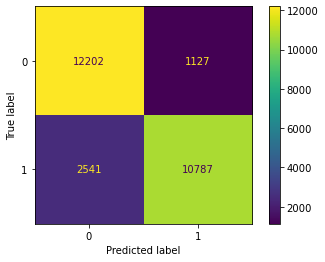

In [44]:
# confusion matrix for the logistic regression model 
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(LR,X_test_SC,y_test);


logistic regression model showes a good fit to the data with 86% accuracy, 87% for precision and 86% for each of recall and F1-score. Also, confusion matrix shows that the model predicted that 2541 of employees are not recommended  for promotion but they actually are. On other hand, the logistic regression model predicted that 1127 of employees are recommended for promotion but  actually they are not. 


- Second Model (Random Forest)

In [41]:
# Train and fit a Random Forest model 
# Evaluate the Random Forest model using test set 


RF= RandomForestClassifier(random_state = 123)
RF.fit(X_train_SC, y_train)
print(f'Random Forest accuracy on test set {RF.score(X_test_SC, y_test)}')

Random Forest accuracy on test set 0.9536707056307911


In [42]:
# classification report for the Random Forest model  

y_pred= RF.predict(X_test_SC)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95     13329
           1       0.97      0.94      0.95     13328

    accuracy                           0.95     26657
   macro avg       0.95      0.95      0.95     26657
weighted avg       0.95      0.95      0.95     26657



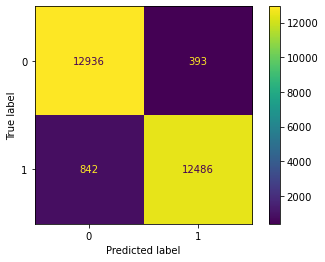

In [45]:
# confusion matrix for the Random Forest model 

plot_confusion_matrix(RF,X_test_SC,y_test);



Random Forest model showes a great fit to the data with 95% for each of recall, precision, F1-score, and accuracy. Also, confusion matrix shows that the model predicted 842 of employees are not recommended for promotion but they actually are. On other hand, the random forest model predicted that 393 of employees are recommended for promotion but actually they are not.

The main objective of this project is to predict the actual employees who most likely to get promoted. The recall of random forest model indicates that 95% of actual promoted employees the classifier correctly identified. Moreover, the random forest model performed well in reducing the False Negative rate in comparison with logistic regression model. Therefore, the random forest model will be chosen as predictive model of this project.

**Feature importance for random forest**

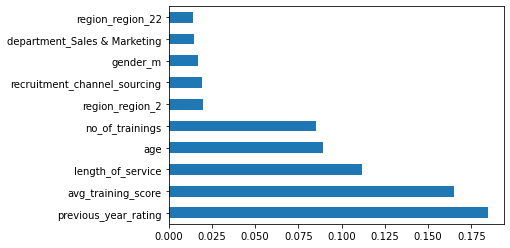

In [47]:
(pd.Series(RF.feature_importances_, index=X_sm.columns)
   .nlargest(10)
   .plot(kind='barh'));

The Feature importance figure for random forest shows that previous year rating is the most important feature in classify our target. The other important features are avg training score, length of service, age, and no of trainings. 

# Conclution 
We have found a good model with an appropriate performance to predict if an employee will be recommended for promotion.

### Thank you. 